In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [1]:
import pymc as pm
pm.__version__

'5.26.1'

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

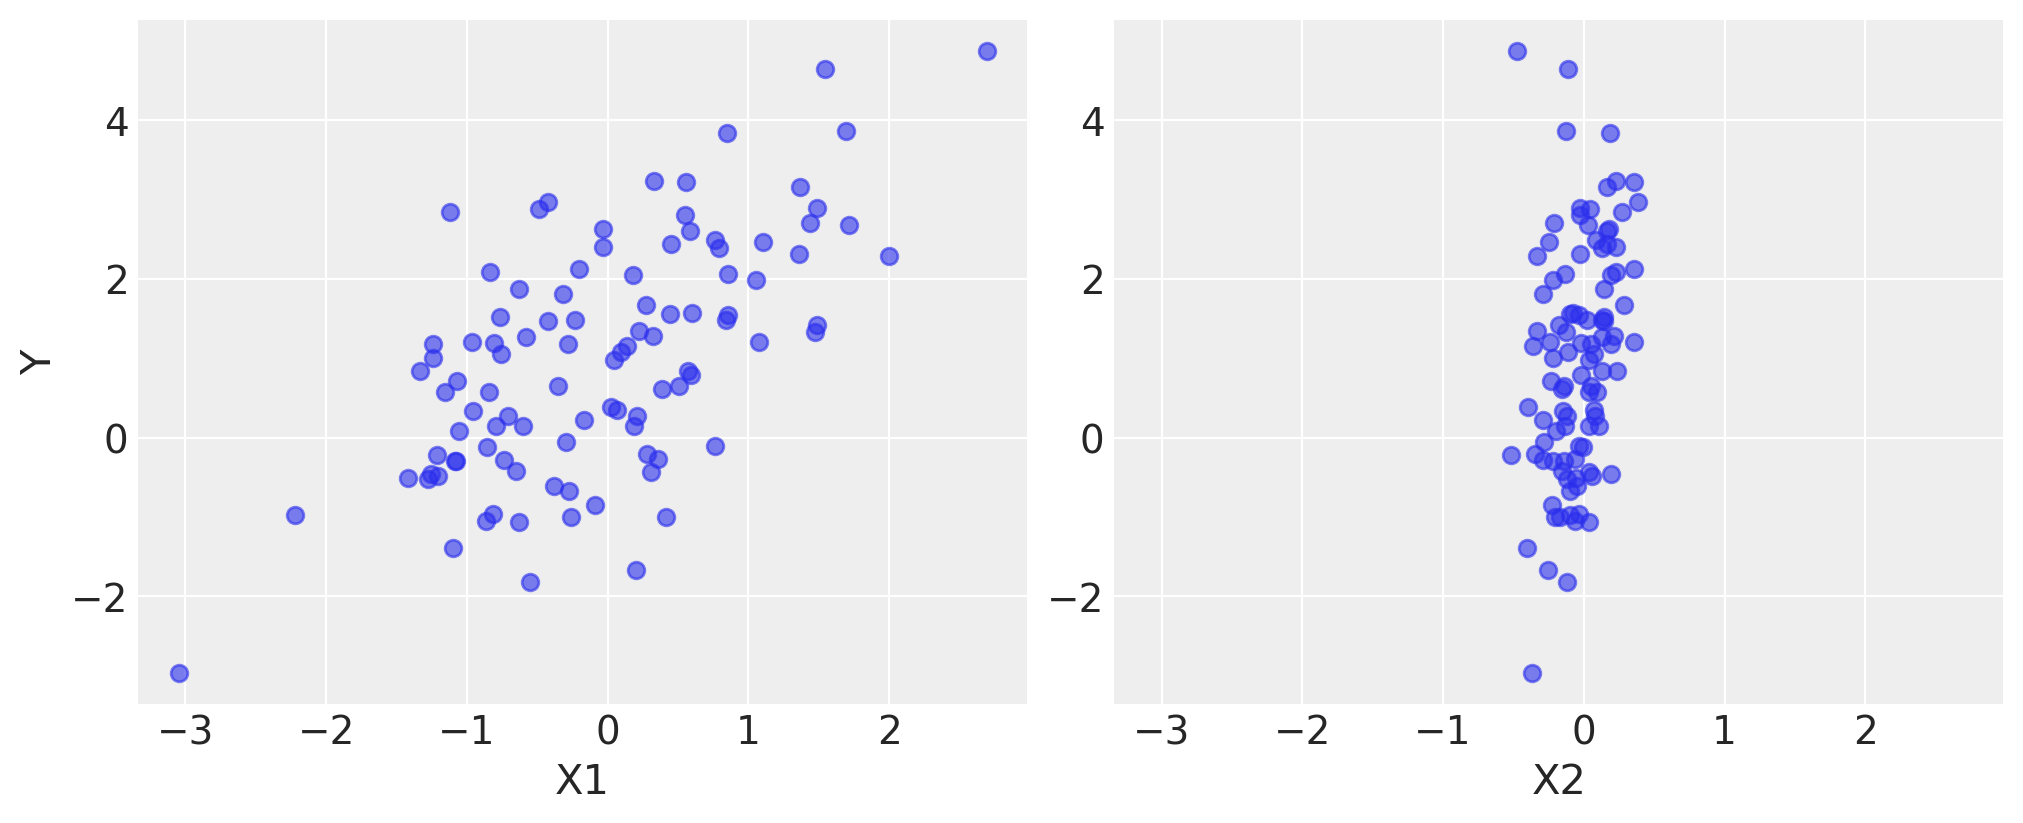

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [6]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [8]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.09220224, 1.28302109, 1.34652923, 1.27343008, 0.89657141],
       [1.15532601, 1.2084071 , 1.1103344 , 1.0547011 , 1.2548952 ],
       [1.19252059, 1.15069772, 1.12559805, 1.09263232, 1.11907795],
       [1.0236904 , 1.36902187, 1.01351727, 1.38069346, 1.33118842]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

In [9]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


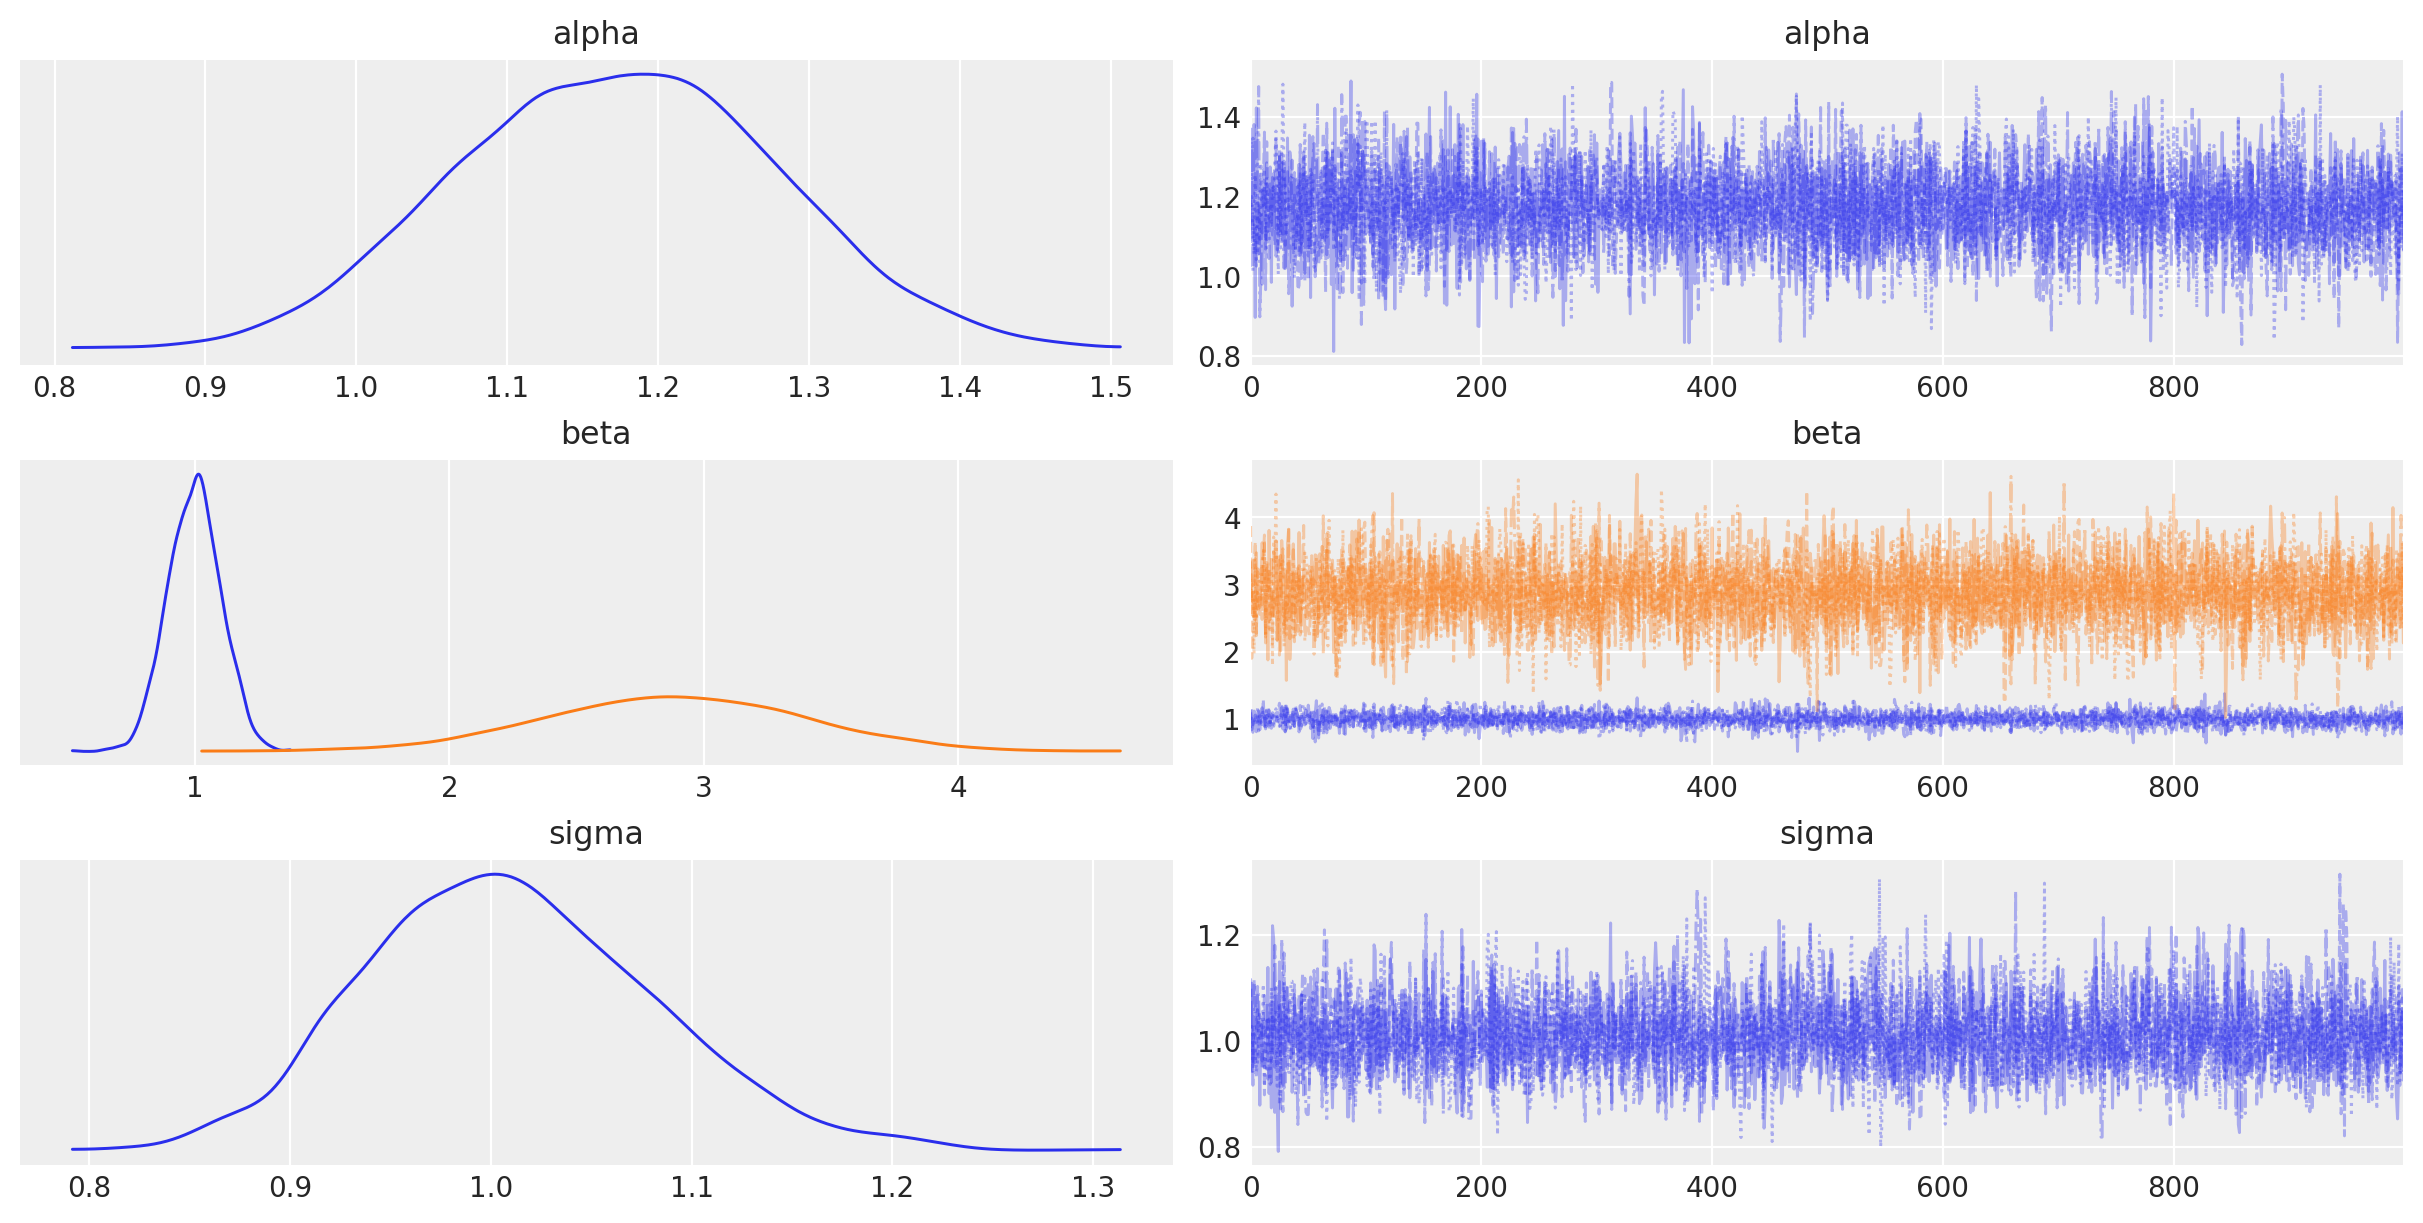

In [10]:
az.plot_trace(idata, combined=True);

In [11]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.17,0.11,0.98,1.38,0.00,0.00,5856.93,2866.44,1.0
beta[0],1.00,0.10,0.81,1.20,0.00,0.00,5379.70,3052.57,1.0
beta[1],2.88,0.51,1.96,3.87,0.01,0.01,5269.01,3339.48,1.0
sigma,1.01,0.07,0.87,1.14,0.00,0.00,5666.33,3077.97,1.0
